# Convolutional Networks

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from neuralnet.classifiers.cnn import *
from neuralnet.data_utils import get_CIFAR10_data
from neuralnet.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from neuralnet.layers import *
from neuralnet.fast_layers import *
from neuralnet.solver import Solver
from neuralnet.fast_layers import conv_forward_fast, conv_backward_fast
from neuralnet.fast_layers import max_pool_forward_fast, max_pool_backward_fast
from neuralnet.layer_utils import conv_relu_forward, conv_relu_backward
from neuralnet.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

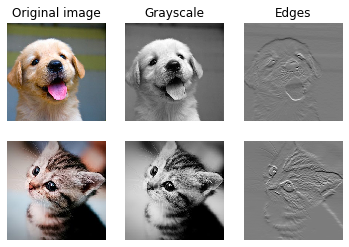

In [3]:
from imageio import imread
from PIL import Image

kitten = imread('notebook_images/kitten.jpg')
puppy = imread('notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `neuralnet/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class.

## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [4]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

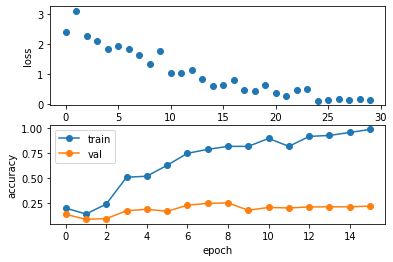

In [5]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [6]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=300, reg=0.001)

solver = Solver(model, data,
                num_epochs=20, batch_size=500,
                update_rule='adam',
                optim_config={
                  'learning_rate': 3e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 1960) loss: 2.303787
(Epoch 0 / 20) train acc: 0.104000; val_acc: 0.107000
(Iteration 21 / 1960) loss: 2.530191
(Iteration 41 / 1960) loss: 2.196479
(Iteration 61 / 1960) loss: 2.151581
(Iteration 81 / 1960) loss: 1.999280
(Epoch 1 / 20) train acc: 0.312000; val_acc: 0.334000
(Iteration 101 / 1960) loss: 1.813233
(Iteration 121 / 1960) loss: 1.739630
(Iteration 141 / 1960) loss: 1.678154
(Iteration 161 / 1960) loss: 1.585734
(Iteration 181 / 1960) loss: 1.666620
(Epoch 2 / 20) train acc: 0.425000; val_acc: 0.416000
(Iteration 201 / 1960) loss: 1.543336
(Iteration 221 / 1960) loss: 1.507673
(Iteration 241 / 1960) loss: 1.501717
(Iteration 261 / 1960) loss: 1.471645
(Iteration 281 / 1960) loss: 1.512191
(Epoch 3 / 20) train acc: 0.505000; val_acc: 0.524000
(Iteration 301 / 1960) loss: 1.367748
(Iteration 321 / 1960) loss: 1.324601
(Iteration 341 / 1960) loss: 1.397488
(Iteration 361 / 1960) loss: 1.334237
(Iteration 381 / 1960) loss: 1.490112
(Epoch 4 / 20) train acc: 0.54

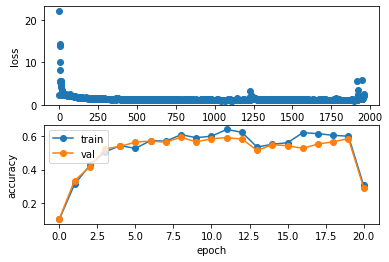

In [7]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

loss_history = []
train_acc_history = []
val_acc_history = []

loss_history.extend(solver.loss_history)
train_acc_history.extend(solver.train_acc_history)
val_acc_history.extend(solver.val_acc_history)

### Saving the model

In [8]:
from neuralnet.save_load import SaveLoad
WORKING_DIR = "/mnt/Alice/ISI/SEM3/NNA/Assignments/assignment5/"
path_to_saved_solver = WORKING_DIR + 'solver.pkl'
SaveLoad.save_object(path_to_saved_solver, solver)

Saving Python Obejct to /mnt/Alice/ISI/SEM3/NNA/Assignments/assignment5/solver.pkl
Python Obejct Saved at /mnt/Alice/ISI/SEM3/NNA/Assignments/assignment5/solver.pkl


In [9]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(solver.model.loss(data['X_test']), axis=1)

print(confusion_matrix(data['y_test'], y_pred))

[[61  2 11  1  2  3  4  0 13  6]
 [ 3 53  2  0  1  1  2  2  6 19]
 [13  0 41  2 12 21  8  1  1  1]
 [ 0  0  9 25  5 46  9  5  2  2]
 [ 8  0 16  3 31 11 12  8  0  1]
 [ 0  0  5  6  5 59  2  9  0  0]
 [ 0  0  6  9  4  8 82  1  1  1]
 [ 3  0  1  2  3 17  0 74  2  0]
 [20  5  0  3  0  0  1  0 76  1]
 [ 3  5  0  0  1  4  2  0  9 85]]


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

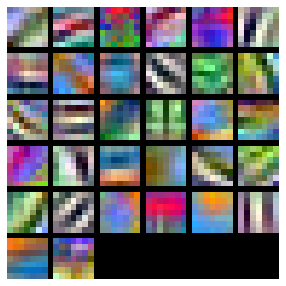

In [10]:
from neuralnet.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()